# <span style='color:Blue'>Titanic - Kaggle </span>
### 79.425%

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from collections import Counter

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve

sns.set(style='white', context='notebook', palette='deep')

In [2]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
IDtest = test["PassengerId"]

In [3]:
def detect_outliers(df,n,features):
    """
    Takes a dataframe df of features and returns a list of the indices
    corresponding to the observations containing more than n outliers according
    to the Tukey method.
    """
    outlier_indices = []
    
    # iterate over features(columns)
    for col in features:
        # 1st quartile (25%)
        Q1 = np.percentile(df[col], 25)
        # 3rd quartile (75%)
        Q3 = np.percentile(df[col],75)
        # Interquartile range (IQR)
        IQR = Q3 - Q1
        
        # outlier step
        outlier_step = 1.5 * IQR
        
        # Determine a list of indices of outliers for feature col
        outlier_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step )].index
        
        # append the found outlier indices for col to the list of outlier indices 
        outlier_indices.extend(outlier_list_col)
        
    # select observations containing more than 2 outliers
    outlier_indices = Counter(outlier_indices)        
    multiple_outliers = list( k for k, v in outlier_indices.items() if v > n )
    
    return multiple_outliers   

# detect outliers from Age, SibSp , Parch and Fare
Outliers_to_drop = detect_outliers(train,2,["Age","SibSp","Parch","Fare"])

C:\Users\MSI\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


In [4]:
train.loc[Outliers_to_drop] # Show the outliers rows

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
27,28,0,1,"Fortune, Mr. Charles Alexander",male,19.0,3,2,19950,263.00,C23 C25 C27,S
88,89,1,1,"Fortune, Miss. Mabel Helen",female,23.0,3,2,19950,263.00,C23 C25 C27,S
159,160,0,3,"Sage, Master. Thomas Henry",male,NaN,8,2,CA. 2343,69.55,NaN,S
180,181,0,3,"Sage, Miss. Constance Gladys",female,NaN,8,2,CA. 2343,69.55,NaN,S
201,202,0,3,"Sage, Mr. Frederick",male,NaN,8,2,CA. 2343,69.55,NaN,S
324,325,0,3,"Sage, Mr. George John Jr",male,NaN,8,2,CA. 2343,69.55,NaN,S
341,342,1,1,"Fortune, Miss. Alice Elizabeth",female,24.0,3,2,19950,263.00,C23 C25 C27,S
792,793,0,3,"Sage, Miss. Stella Anna",female,NaN,8,2,CA. 2343,69.55,NaN,S
846,847,0,3,"Sage, Mr. Douglas Bullen",male,NaN,8,2,CA. 2343,69.55,NaN,S
863,864,0,3,"Sage, Miss. Dorothy Edith ""Dolly""",female,NaN,8,2,CA. 2343,69.55,NaN,S


In [5]:
train = train.drop(Outliers_to_drop, axis = 0).reset_index(drop=True)

In [6]:
## Join train and test datasets in order to obtain the same number of features during categorical conversion
train_len = len(train)
dataset =  pd.concat(objs=[train, test], axis=0).reset_index(drop=True)

ipykernel_launcher:3: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



In [7]:
# Fill empty and NaNs values with NaN
dataset = dataset.fillna(np.nan)

# Check for Null values
dataset.isnull().sum()

Age             256
Cabin          1007
Embarked          2
Fare              1
Name              0
Parch             0
PassengerId       0
Pclass            0
Sex               0
SibSp             0
Survived        418
Ticket            0
dtype: int64

In [8]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,881.000000,881.000000,881.000000,711.000000,881.000000,881.000000,881.000000
mean,446.713961,0.385925,2.307605,29.731603,0.455165,0.363224,31.121566
std,256.617021,0.487090,0.835055,14.547835,0.871571,0.791839,47.996249
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,226.000000,0.000000,2.000000,20.250000,0.000000,0.000000,7.895800
50%,448.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.000000,1.000000,3.000000,38.000000,1.000000,0.000000,30.500000
max,891.000000,1.000000,3.000000,80.000000,5.000000,6.000000,512.329200


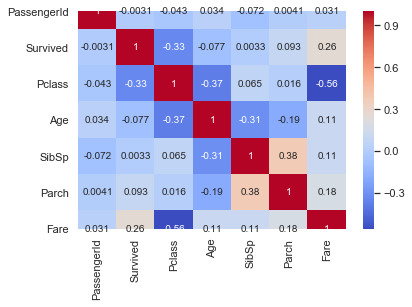

In [9]:
sns.heatmap(train.corr(), cmap="coolwarm", annot=True)

C:\Users\MSI\Anaconda3\lib\site-packages\seaborn\categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
C:\Users\MSI\Anaconda3\lib\site-packages\seaborn\categorical.py:3672: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


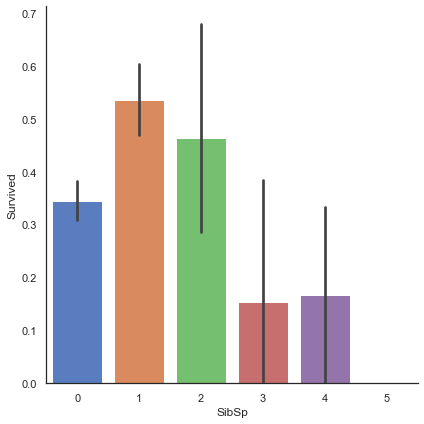

In [10]:
sns.factorplot(x="SibSp", y="Survived", data=train, kind="bar", size=6, palette = "muted")

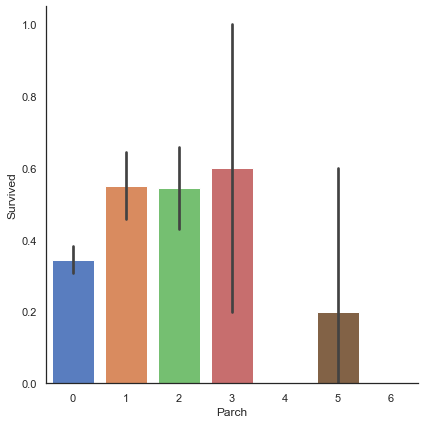

In [11]:
sns.factorplot(x="Parch", y="Survived", data=train, kind="bar", size=6, palette = "muted")

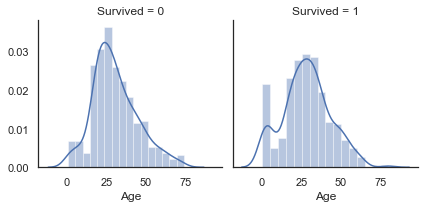

In [12]:
g = sns.FacetGrid(train, col="Survived")
g = g.map(sns.distplot, "Age")

In [13]:
dataset["Fare"].isnull().sum()

1

In [14]:
dataset["Fare"] = dataset["Fare"].fillna(dataset["Fare"].median())

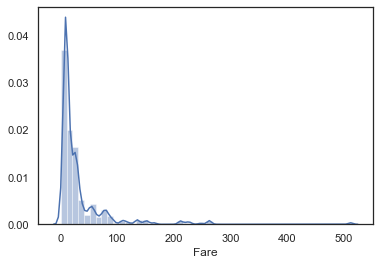

In [15]:
sns.distplot(dataset["Fare"])

In [16]:
dataset["Fare"] = dataset["Fare"].map(lambda i: np.log(i) if i > 0 else 0)

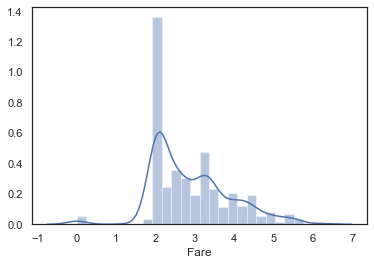

In [17]:
sns.distplot(dataset["Fare"])

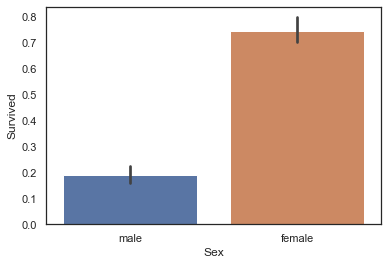

In [18]:
sns.barplot(x="Sex", y="Survived", data=train)

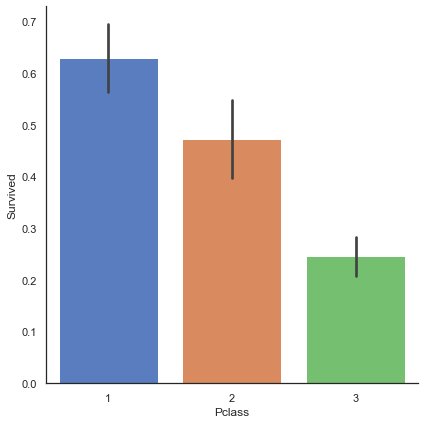

In [19]:
sns.factorplot(x="Pclass", y="Survived", data=train, kind="bar", size=6, palette = "muted")

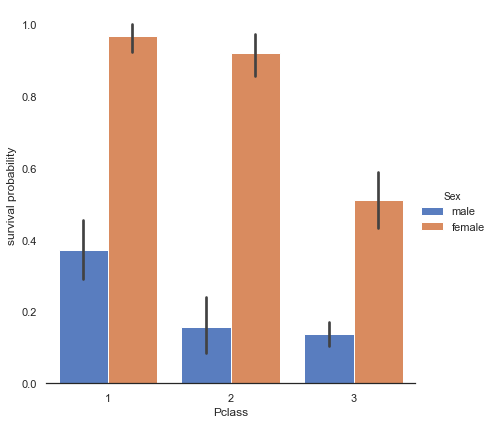

In [20]:
# Explore Pclass vs Survived by Sex
g = sns.factorplot(x="Pclass", y="Survived", hue="Sex", data=train,
                   size=6, kind="bar", palette="muted")
g.despine(left=True)
g = g.set_ylabels("survival probability")

In [21]:
dataset["Embarked"] = dataset["Embarked"].fillna("S")

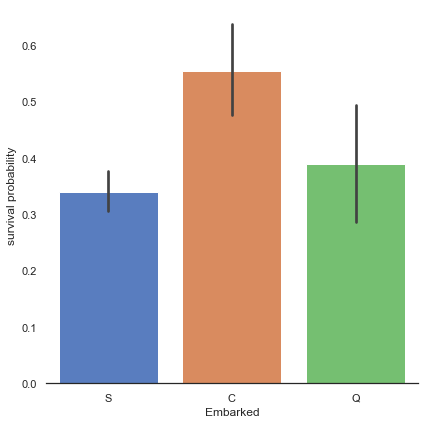

In [22]:
# Explore Embarked vs Survived 
g = sns.factorplot(x="Embarked", y="Survived",  data=train,
                   size=6, kind="bar", palette="muted")
g.despine(left=True)
g = g.set_ylabels("survival probability")

C:\Users\MSI\Anaconda3\lib\site-packages\seaborn\categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
C:\Users\MSI\Anaconda3\lib\site-packages\seaborn\categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
C:\Users\MSI\Anaconda3\lib\site-packages\seaborn\categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg

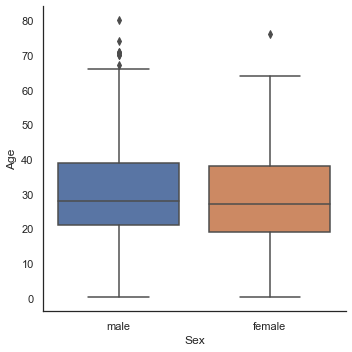

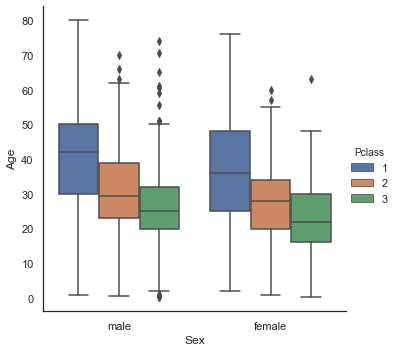

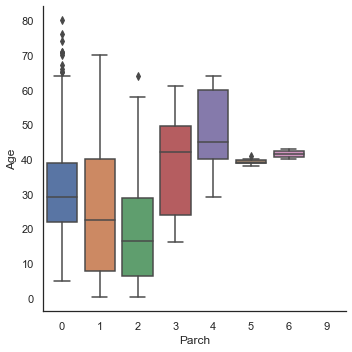

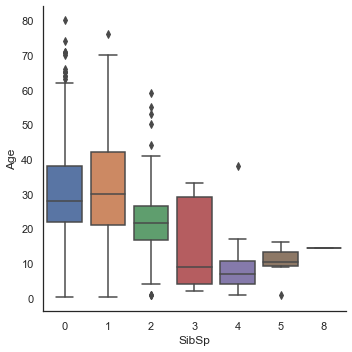

In [23]:
# Explore Age vs Sex, Parch , Pclass and SibSP
g = sns.factorplot(y="Age",x="Sex",data=dataset,kind="box")
g = sns.factorplot(y="Age",x="Sex",hue="Pclass", data=dataset,kind="box")
g = sns.factorplot(y="Age",x="Parch", data=dataset,kind="box")
g = sns.factorplot(y="Age",x="SibSp", data=dataset,kind="box")

In [24]:
dataset["Sex"] = dataset["Sex"].map({"male":0, "female":1})

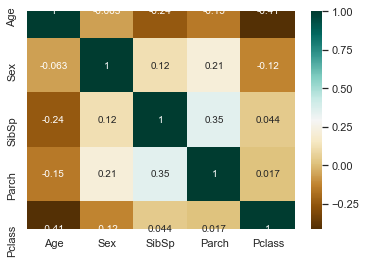

In [25]:
sns.heatmap(dataset[["Age","Sex","SibSp","Parch","Pclass"]].corr(),cmap="BrBG",annot=True)

In [26]:
# Filling missing value of Age 

## Fill Age with the median age of similar rows according to Pclass, Parch and SibSp
# Index of NaN age rows
index_NaN_age = list(dataset["Age"][dataset["Age"].isnull()].index)

for i in index_NaN_age :
    age_med = dataset["Age"].median()
    age_pred = dataset["Age"][((dataset['SibSp'] == dataset.iloc[i]["SibSp"]) & (dataset['Parch'] == dataset.iloc[i]["Parch"]) & (dataset['Pclass'] == dataset.iloc[i]["Pclass"]))].median()
    if not np.isnan(age_pred) :
        dataset['Age'].iloc[i] = age_pred
    else :
        dataset['Age'].iloc[i] = age_med

C:\Users\MSI\Anaconda3\lib\site-packages\pandas\core\indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


C:\Users\MSI\Anaconda3\lib\site-packages\seaborn\categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


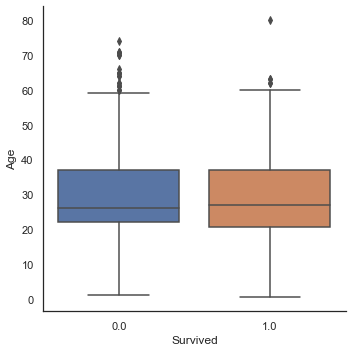

In [27]:
# Explore Age vs Sex, Parch , Pclass and SibSP
g = sns.factorplot(y="Age",x="Survived",data=dataset,kind="box")


In [28]:
dataset.head()

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket
0,22.0,NaN,S,1.981001,"Braund, Mr. Owen Harris",0,1,3,0,1,0.0,A/5 21171
1,38.0,C85,C,4.266662,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,1,1,1.0,PC 17599
2,26.0,NaN,S,2.070022,"Heikkinen, Miss. Laina",0,3,3,1,0,1.0,STON/O2. 3101282
3,35.0,C123,S,3.972177,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,1,1,1.0,113803
4,35.0,NaN,S,2.085672,"Allen, Mr. William Henry",0,5,3,0,0,0.0,373450


In [29]:
dataset_title = [i.split(",")[1].split(".")[0].strip() for i in dataset["Name"]]
dataset["Title"] = pd.Series(dataset_title)
dataset["Title"].head()

0      Mr
1     Mrs
2    Miss
3     Mrs
4      Mr
Name: Title, dtype: object

In [30]:
Counter(dataset["Title"])

Counter({'Mr': 753,
         'Mrs': 197,
         'Miss': 255,
         'Master': 60,
         'Don': 1,
         'Rev': 8,
         'Dr': 8,
         'Mme': 1,
         'Ms': 2,
         'Major': 2,
         'Lady': 1,
         'Sir': 1,
         'Mlle': 2,
         'Col': 4,
         'Capt': 1,
         'the Countess': 1,
         'Jonkheer': 1,
         'Dona': 1})

In [31]:
# Convert to categorical values Title 
dataset["Title"] = dataset["Title"].replace(['Lady', 'the Countess','Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
dataset["Title"] = dataset["Title"].map({"Master":0, "Miss":1, "Ms" : 1 , "Mme":1, "Mlle":1, "Mrs":1, "Mr":2, "Rare":3})
dataset["Title"] = dataset["Title"].astype(int)

In [32]:
dataset.drop(labels = ["Name"], axis = 1, inplace = True)
dataset.describe()

,Age,Fare,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Title
count,1299.000000,1299.000000,1299.000000,1299.000000,1299.000000,1299.000000,1299.000000,881.000000,1299.000000
mean,29.275343,2.897085,0.372594,657.093149,2.294072,0.354888,0.452656,0.385925,1.578137
std,13.271220,0.994704,0.857157,377.743244,0.837150,0.478664,0.879416,0.487090,0.617427
min,0.170000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,22.000000,2.066331,0.000000,331.500000,2.000000,0.000000,0.000000,0.000000,1.000000
50%,26.000000,2.670985,0.000000,657.000000,3.000000,0.000000,0.000000,0.000000,2.000000
75%,37.000000,3.420926,0.000000,984.500000,3.000000,1.000000,1.000000,1.000000,2.000000
max,80.000000,6.238967,9.000000,1309.000000,3.000000,1.000000,8.000000,1.000000,3.000000


In [33]:
dataset["Fsize"] = dataset["SibSp"]+dataset["Parch"]+1

C:\Users\MSI\Anaconda3\lib\site-packages\seaborn\categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


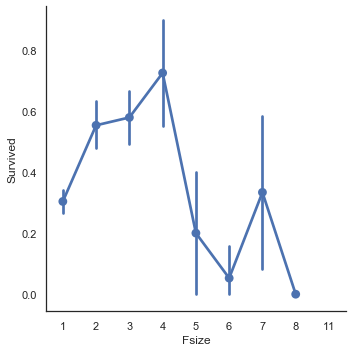

In [34]:
sns.factorplot(x="Fsize", y="Survived", data=dataset)

In [35]:
dataset = pd.get_dummies(dataset, columns = ["Title"])
dataset = pd.get_dummies(dataset, columns = ["Embarked"], prefix="Em")

In [36]:
dataset["Cabin"] = pd.Series([i[0] if not pd.isnull(i) else "X" for i in dataset["Cabin"]])

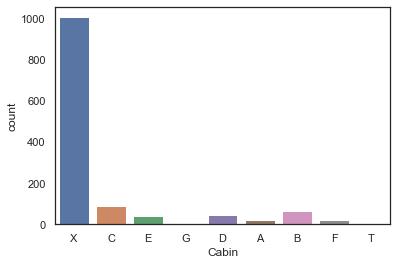

In [37]:
sns.countplot(dataset["Cabin"])

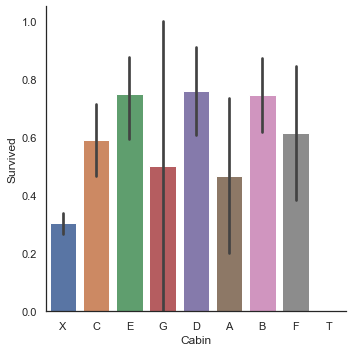

In [38]:
sns.factorplot(y="Survived", x="Cabin", data=dataset, kind="bar")

In [39]:
dataset["Cabin"] = dataset["Cabin"].map({"T":0, "A":1, "B":2, "C":3, "D":4, "E":5, "F":6, "G":7, "X":8})
dataset["Cabin"] = dataset["Cabin"].astype(int)

In [40]:
# dataset = pd.get_dummies(dataset,columns="Cabin", prefix="Cabin")

In [41]:
d = dataset.copy()

In [42]:
# d = pd.get_dummies(d,columns="Cabin", prefix="cb")
# d.head()

In [43]:
dataset["Pclass"] = dataset["Pclass"].astype("category")
dataset = pd.get_dummies(dataset, columns = ["Pclass"],prefix="Pc")


In [44]:
Ticket = []
for i in list(dataset.Ticket):
    if not i.isdigit() :
        Ticket.append(i.replace(".","").replace("/","").strip().split(' ')[0]) #Take prefix
    else:
        Ticket.append("X")
        
dataset["Ticket"] = Ticket
dataset["Ticket"].head()

0        A5
1        PC
2    STONO2
3         X
4         X
Name: Ticket, dtype: object

In [45]:
dataset.drop(labels = ["PassengerId"], axis = 1, inplace = True)

In [46]:
dataset = pd.get_dummies(dataset, columns = ["Ticket"], prefix="T")
dataset.head()

,Age,Cabin,Fare,Parch,Sex,SibSp,Survived,Fsize,Title_0,Title_1,...,T_SOTONO2,T_SOTONOQ,T_SP,T_STONO,T_STONO2,T_STONOQ,T_SWPP,T_WC,T_WEP,T_X
0,22.0,8,1.981001,0,0,1,0.0,2,0,0,...,0,0,0,0,0,0,0,0,0,0
1,38.0,3,4.266662,0,1,1,1.0,2,0,1,...,0,0,0,0,0,0,0,0,0,0
2,26.0,8,2.070022,0,1,0,1.0,1,0,1,...,0,0,0,0,1,0,0,0,0,0
3,35.0,3,3.972177,0,1,1,1.0,2,0,1,...,0,0,0,0,0,0,0,0,0,1
4,35.0,8,2.085672,0,0,0,0.0,1,0,0,...,0,0,0,0,0,0,0,0,0,1


In [47]:
train = dataset[:train_len]
test = dataset[train_len:]
test.drop(labels=["Survived"],axis = 1,inplace=True)

C:\Users\MSI\Anaconda3\lib\site-packages\pandas\core\frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [48]:
train["Survived"] = train["Survived"].astype(int)

Y_train = train["Survived"]

X_train = train.drop(labels = ["Survived"],axis = 1)

ipykernel_launcher:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [49]:
# from logistic_regression import LogisticRegression
model = LogisticRegression(random_state=2, max_iter=1000)
# model = RandomForestClassifier(random_state=2)
model.fit(X_train, Y_train)

LogisticRegression(max_iter=1000, random_state=2)

In [62]:
# Cross validate model with Kfold stratified cross val
kfold = StratifiedKFold(n_splits=10)

In [51]:
pred = model.predict(test)

In [52]:
id = [i for i in range(892, 1310)]
arr = np.c_[id, pred]
dfR = pd.DataFrame(arr, columns=['PassengerId','Survived'])
dfR.to_csv('pred.csv', index=False, header=True, sep=',')

## Parameter Tuning

In [54]:
# RFC Parameters tunning 
RFC = RandomForestClassifier()


## Search grid for optimal parameters
rf_param_grid = {"max_depth": [None],
              "max_features": [1, 3, 10],
              "min_samples_split": [2, 3, 10],
              "min_samples_leaf": [1, 3, 10],
              "bootstrap": [False],
              "n_estimators" :[100,300],
              "criterion": ["gini"]}


gsRFC = GridSearchCV(RFC,param_grid = rf_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)

gsRFC.fit(X_train,Y_train)

RFC_best = gsRFC.best_estimator_

# Best score
gsRFC.best_score_

Fitting 10 folds for each of 54 candidates, totalling 540 fits
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    5.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   11.9s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   27.4s
[Parallel(n_jobs=4)]: Done 540 out of 540 | elapsed:   34.1s finished


0.831996935648621

In [60]:
pred_gs = gsRFC.predict(test)

In [61]:
id_gs = [i for i in range(892, 1310)]
arr_gs = np.c_[id_gs, pred_gs]
dfR_gs = pd.DataFrame(arr_gs, columns=['PassengerId','Survived'])
dfR_gs.to_csv('pred_gs.csv', index=False, header=True, sep=',')